<a href="https://colab.research.google.com/github/ArnavKetkar/Pytorch/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Get data

Our dataset  is a subset of Food101 Dataset.
We have 3 classes of food and ~75 training and ~25 testing images per class.

It is always better to start small and increase scale when necessary.

WHole point is to speed up how fast you experiment

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If image folder doesn't exist, download it and prepare
if image_path.is_dir():
  print(f"{image_path} directory already exists")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", 'wb') as f:
  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print('Downloading data....')
  f.write(request.content)

# Unzip data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
  print("Unzipping data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unzipping data...


## Data preparation and exploration

In [4]:
import os
def walk_through_dir(dir_path):
  """ Walks through dir_path returning its contents """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in' {dirpath}'")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in' data/pizza_steak_sushi'
There are 3 directories and 0 images in' data/pizza_steak_sushi/test'
There are 0 directories and 25 images in' data/pizza_steak_sushi/test/pizza'
There are 0 directories and 31 images in' data/pizza_steak_sushi/test/sushi'
There are 0 directories and 19 images in' data/pizza_steak_sushi/test/steak'
There are 3 directories and 0 images in' data/pizza_steak_sushi/train'
There are 0 directories and 78 images in' data/pizza_steak_sushi/train/pizza'
There are 0 directories and 72 images in' data/pizza_steak_sushi/train/sushi'
There are 0 directories and 75 images in' data/pizza_steak_sushi/train/steak'


In [6]:
# Setup training and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Visualizing image

Random image path: data/pizza_steak_sushi/test/steak/1285886.jpg
Image class: steak
Image height: 512
Image width: 512


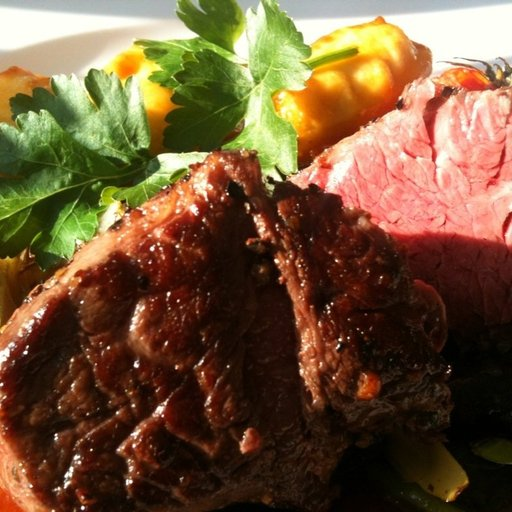

In [7]:
import random
from PIL import Image

# Set seed
random.seed(42)

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Pick a random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

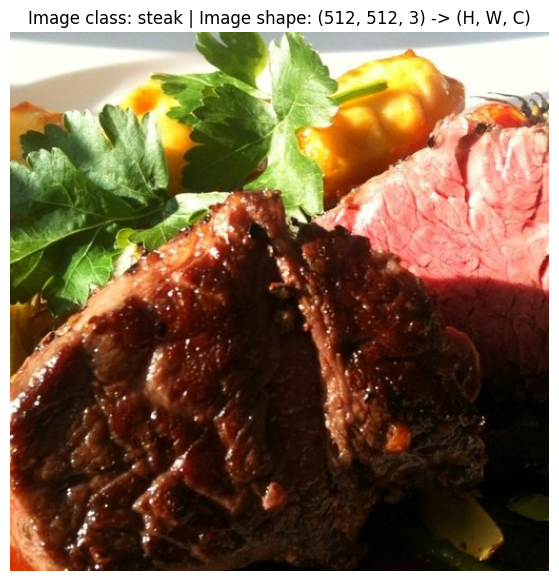

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image into array
img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array) # plt.imshow(img) also works
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> (H, W, C)")
plt.axis(False)

## Transforming data

1. Turn target data into tensors,
2. Turn it into `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DalaLoader`

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Transforming data with `torchvision.transforms`

In [10]:
data_transform = transforms.Compose([
    # Resize image to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the images to torch.Tensor
    transforms.ToTensor()
])

In [11]:
data_transform(img)

tensor([[[0.7569, 0.7412, 0.7255,  ..., 0.8275, 0.8588, 0.8824],
         [0.9647, 0.9529, 0.9412,  ..., 0.9843, 0.9922, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.8824, 0.9255, 0.9333,  ..., 0.0275, 0.0353, 0.0353],
         [0.8431, 0.8627, 0.9098,  ..., 0.0314, 0.0392, 0.0431],
         [0.8275, 0.8314, 0.8588,  ..., 0.0353, 0.0471, 0.0549]],

        [[0.7922, 0.7725, 0.7569,  ..., 0.8627, 0.8863, 0.9098],
         [0.9765, 0.9647, 0.9490,  ..., 0.9922, 0.9961, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.3725, 0.5529, 0.6431,  ..., 0.0275, 0.0353, 0.0353],
         [0.2588, 0.3725, 0.5569,  ..., 0.0314, 0.0353, 0.0353],
         [0.2235, 0.2392, 0.3843,  ..., 0.0353, 0.0392, 0.0392]],

        [[0.7725, 0.7647, 0.7569,  ..., 0.8627, 0.8902, 0.8980],
         [0.9451, 0.9412, 0.9294,  ..., 0.9608, 0.9647, 0.9686],
         [0.9686, 0.9686, 0.9686,  ..., 0.9686, 0.9686, 0.

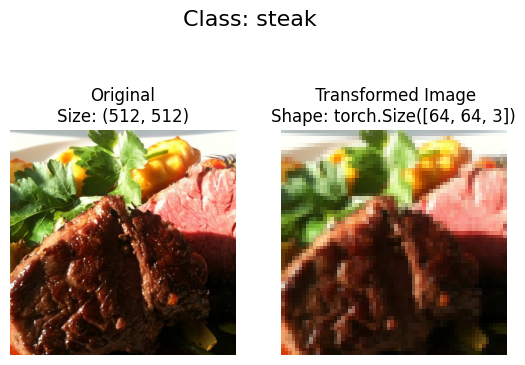

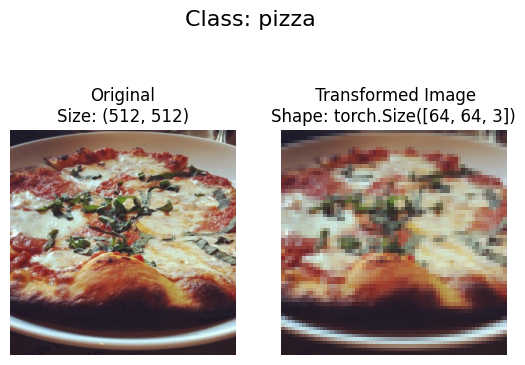

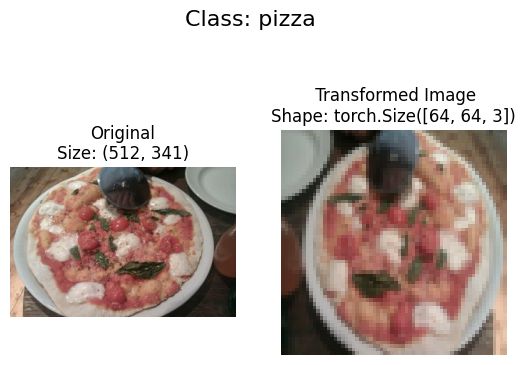

In [12]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """ Selects random images from path, then loads and transforms them
   then plots original vs. trasnformed image"""

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)
      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f" Transformed Image\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## Option 1: Loading image data using `torchvision.datasets.ImageFolder`

In [13]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Get class names as dict
class_dict =train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
img, label = train_data[0][0], train_data[0][1]

In [17]:
img

tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0902, 0.0902, 0.

Text(0.5, 1.0, 'pizza')

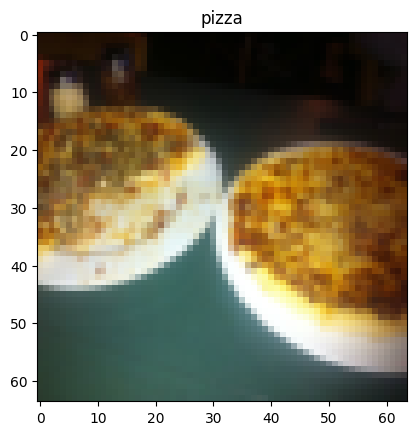

In [18]:
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])

## Turn loaded images to data Loaders

In [19]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7cee5529a380>,
 <torch.utils.data.dataloader.DataLoader at 0x7cee5529a3e0>)

In [20]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [B, C, H, W]")
print(f"label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [B, C, H, W]
label shape: torch.Size([1])


## Option 2: Loasing image data with custom `Dataset`

1. Load images from file
2. Get class names from Dataset

In [21]:
import os
import torch
import pathlib

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

### Creating a helper function to get class names

We wamt function to:
1. Get class names uing `os.scandir()` to traverse target directory.
2. Raise error if class names not found
3. Turn class names into list and dict

In [22]:
target_directory = train_dir
print(f'Target directory: {target_directory}')

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [23]:
list(os.scandir(target_directory))[0].name

'pizza'

In [24]:
def find_classes(dir: str) -> Tuple[List[str], Dict[str, int]]:
  """ Find class folder names in a target directory """
  classes = sorted([entry.name for entry in os.scandir(dir) if entry.is_dir()])

  # Raise error if class name could not be found
  if not classes:
    raise FileNotFoundError(f" Couldn't find any classes in {dir}...check file structure")

  # Create dict of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

  return classes, class_to_idx

In [25]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create custom `Dataset` to recreate `ImageFolder`

In [26]:
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. Create class attributes
    # Get image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create function to load images
  def load_image(self, index: int) -> Image.Image:
    """ Open image via path and opens it """
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    """ Return total number of samples """
    return len(self.paths)

  # 6. Overwrite __getitem__() to return particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """ Returns one sample of data, data and label (X, y) """
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # Expects path in format data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # returns data, label
    else:
      return img, class_idx


In [27]:
# Create transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [28]:
train_data_custom = ImageFolderCustom(train_dir,
                                      train_transforms)

test_data_custom = ImageFolderCustom(test_dir,
                                     test_transforms)

In [29]:
len(train_data), len(train_data_custom)

(225, 225)

In [30]:
(train_data_custom).class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

### Create function to display random images

1. Take in a `Dataset` and parameters like class names, #images to visualize
2. Cap number of images to be diplayed to 10
3. Set seed
4. Get list of random samples from target dataset
5. Loop through random samples and plot with matplotlib
6. Check dimensions

In [31]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None
                          ):
  if n>10:
    n=10
    display_shape = False
    print(f" For display purposes, showing only 10 images")

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize = (16, 8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_img, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    targ_image = targ_img.permute(1, 2, 0)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image)
    plt.axis(False)
    if classes:
      title = f"Class:  {classes[targ_label]}"
      if display_shape:
        title = title + f"\nShape: {targ_image.shape}"
    plt.title(title)


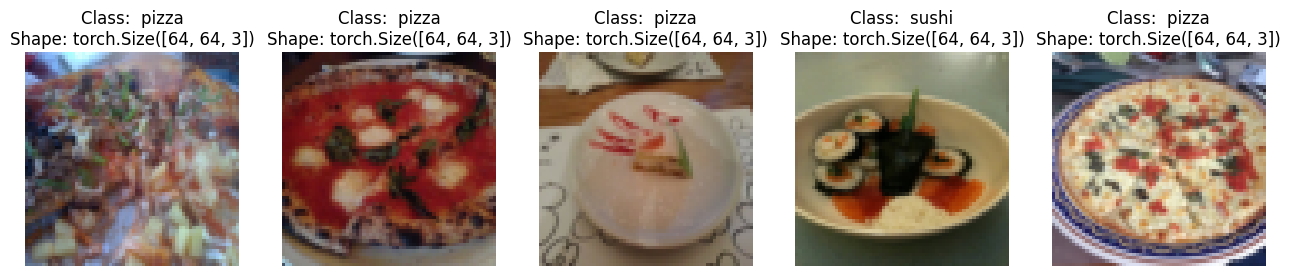

In [32]:
display_random_images(train_data,
                      class_names,
                      n=5)

 For display purposes, showing only 10 images


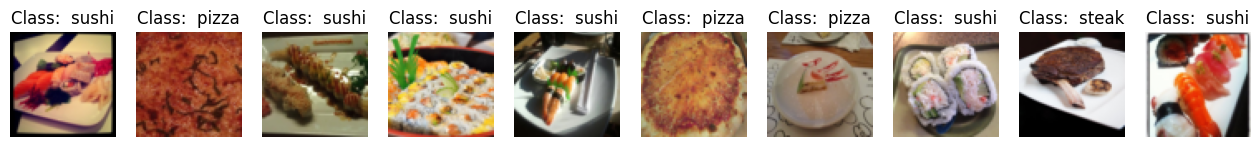

In [33]:
display_random_images(train_data_custom,
                      n=100,
                      classes=class_names,
                      seed=10)

### Turn custom loaded images to `DataLoader`'s

In [34]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7cee5522e110>,
 <torch.utils.data.dataloader.DataLoader at 0x7cee5524f250>)

In [35]:
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## Data Augmentation

Process of artificially adding diversity to training data

In [36]:
# Let's look at trivialaugment
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [37]:
image_path

PosixPath('data/pizza_steak_sushi')

In [38]:
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/pizza/648055.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3475871.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/971934.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2236338.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2871261.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/344397.jpg')]

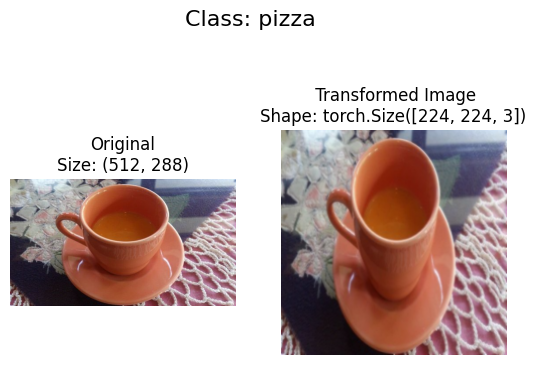

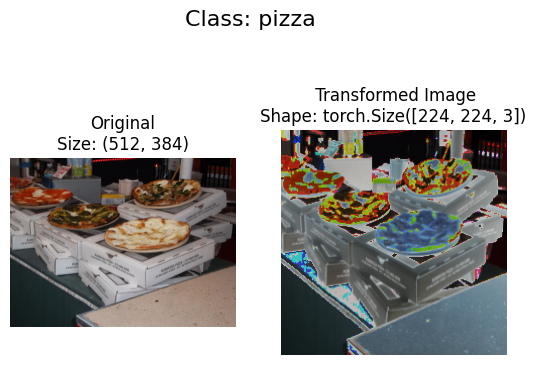

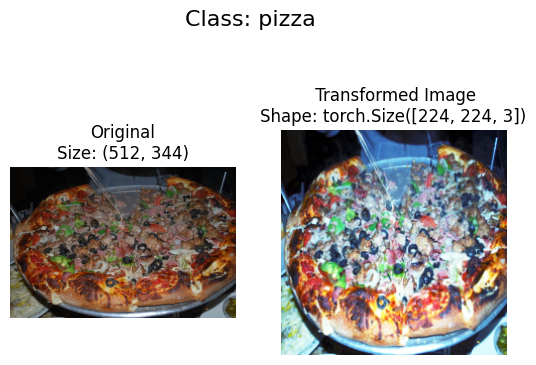

In [39]:
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transforms,
                        n=3,
                        seed=None)

## Building model0: TinyVGG without data augmentation

### Creating transforms and loading data

In [40]:
# Creating transform
from torchvision import transforms
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [41]:
# Loading data using image folder
from torchvision import datasets

train_data_simple = datasets.ImageFolder(train_dir,
                                  transform=simple_transform)

test_data_simple = datasets.ImageFolder(test_dir,
                                 transform=simple_transform)

# Batchifying data using data loaders
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_simple = DataLoader(train_data_simple,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

In [42]:
NUM_WORKERS

2

### Create TinyVGG model class

In [43]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block2 = nn.Sequential(
    nn.Conv2d(in_channels=hidden_units,
              out_channels=hidden_units,
              kernel_size=3,
              stride=1,
              padding=0),
    nn.ReLU(),
    nn.Conv2d(in_channels=hidden_units,
              out_channels=hidden_units,
              kernel_size=3,
              stride=1,
              padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,
                  stride=2)

    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    # x = self.conv_block1(x)
    # print(x.shape)
    # x = self.conv_block2(x)
    # print(x.shape)
    # x = self.classifier(x)
    # print(x.shape)
    # return x
    return(self.classifier(self.conv_block2(self.conv_block1(x)))) # -> this is much more efficient because of operator fusion


In [44]:
torch.manual_seed(42)
model0 = TinyVGG(input_shape=3,
                 hidden_units=10,
                 output_shape=len(class_names)).to(device)

model0

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### Try forward pass on single image to test model

In [45]:
# Get single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [46]:
model0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### Use `torchinfo` to get info about shapes across layers

In [47]:
try:
  import torchinfo
except:
  !pip install -q torchinfo
  import torchinfo

from torchinfo import summary
summary(model0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### Creating training and testing loop functions

In [48]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn,
               optimizer: torch.optim.Optimizer,
               device: torch.device=device):

  model.train()

  train_loss, train_acc= 0, 0

  # Loop through the batches
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred  = model(X)

    # Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimizer zero grad
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # Optimizer update
    optimizer.step()

    # Calculate accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=-1)
    train_acc += (y_pred_class==y).sum().item() / len(y_pred)

  # Find average training loss and accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc


In [49]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn,
              device: torch.device=device):

  model.eval()
  with torch.inference_mode():
    test_loss, test_acc = 0, 0
    for batch, (X_test, y_test) in enumerate(dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)

      # Forward pass
      test_pred = model(X_test)

      # Calculate loss
      loss = loss_fn(test_pred, y_test)
      test_loss += loss.item()

      # Calculate accuracy
      test_pred_class = torch.argmax(torch.softmax(test_pred, dim=1), dim=-1)
      test_acc += ((test_pred_class == y_test).sum().item() / len(test_pred))

    # find average test loss and accuracy per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc


### Create a `train()` function to combine `train_step()` and `test_step()` functions

In [50]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device: torch.device = device
          ):

  # Create an empty results dictionary
  results = {"train_loss":[],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through epochs
  for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------------")
    train_loss, train_acc = train_step(model=model,
               dataloader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               device=device)
    test_loss, test_acc = test_step(model=model,
              dataloader=test_dataloader,
              loss_fn=loss_fn,
              device=device)

    # Print what's happening
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}\n")

    # Update results dictionary
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

  return results

### Train and evaluate model0

In [51]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model0 = TinyVGG(input_shape=3,
                 hidden_units=10,
                 output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(),
                            lr = 0.001)

from timeit import default_timer as timer
start_time = timer()

model0_results = train(model=model0,
                       train_dataloader=train_dataloader_simple,
                       test_dataloader=test_dataloader_simple,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
------------
Train Loss: 1.1063 | Train Acc: 0.3047 | Test Loss: 1.0983 | Test Acc: 0.3011

Epoch: 1
------------
Train Loss: 1.0998 | Train Acc: 0.3281 | Test Loss: 1.0697 | Test Acc: 0.5417

Epoch: 2
------------
Train Loss: 1.0869 | Train Acc: 0.4883 | Test Loss: 1.0809 | Test Acc: 0.4924

Epoch: 3
------------
Train Loss: 1.0846 | Train Acc: 0.4023 | Test Loss: 1.0605 | Test Acc: 0.5729

Epoch: 4
------------
Train Loss: 1.0662 | Train Acc: 0.4219 | Test Loss: 1.0658 | Test Acc: 0.5644

Total training time: 9.417 seconds


In [52]:
model0_results

{'train_loss': [1.106320008635521,
  1.0997929573059082,
  1.086891695857048,
  1.0846147388219833,
  1.0661997348070145],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.40234375, 0.421875],
 'test_loss': [1.0983202854792278,
  1.0697002410888672,
  1.0808677673339844,
  1.0605464776357014,
  1.0657918055852253],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5729166666666666,
  0.5643939393939394]}

### Plot loss curves for model0




In [53]:
import matplotlib.pyplot as plt

model0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [54]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """ Plot loss curves of results dictionary """
  loss = results['train_loss']
  test_loss = results['test_loss']
  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(15, 7))

  # Plot the losses
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracies
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

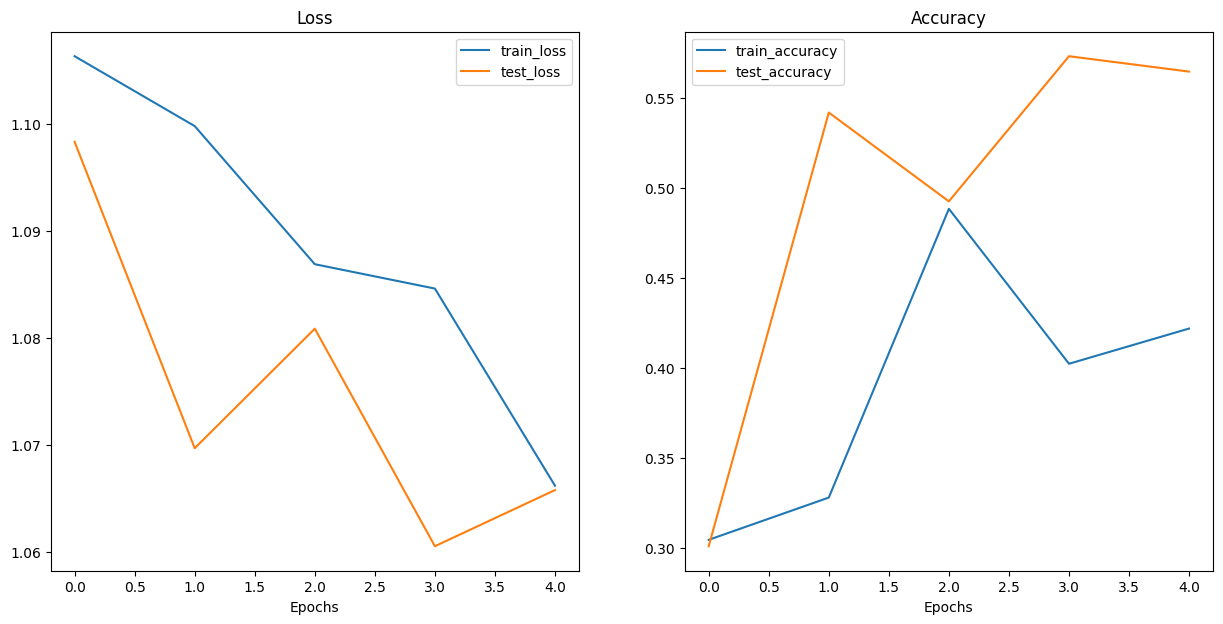

In [55]:
plot_loss_curves(model0_results)

## TinyVGG with data augmentation

### Create transform with data augmentation

In [56]:
from torchvision import transforms
train_transforms_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [57]:
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transforms_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                           transform=test_transforms_trivial)

from torch.utils.data import DataLoader
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_augmented = DataLoader(train_data_augmented,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

### Construct and train model1

In [58]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model1 = TinyVGG(input_shape=3,
                 hidden_units=10,
                 output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model1.parameters(),
                            lr = 0.001)

from timeit import default_timer as timer
start_time = timer()

model1_results = train(model=model1,
                       train_dataloader=train_dataloader_augmented,
                       test_dataloader=test_dataloader_simple,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
------------
Train Loss: 1.1069 | Train Acc: 0.3047 | Test Loss: 1.0993 | Test Acc: 0.2708

Epoch: 1
------------
Train Loss: 1.1019 | Train Acc: 0.3203 | Test Loss: 1.0719 | Test Acc: 0.5417

Epoch: 2
------------
Train Loss: 1.0917 | Train Acc: 0.4375 | Test Loss: 1.0846 | Test Acc: 0.4924

Epoch: 3
------------
Train Loss: 1.0915 | Train Acc: 0.3125 | Test Loss: 1.0678 | Test Acc: 0.5833

Epoch: 4
------------
Train Loss: 1.0862 | Train Acc: 0.3555 | Test Loss: 1.0751 | Test Acc: 0.5436

Total training time: 9.742 seconds


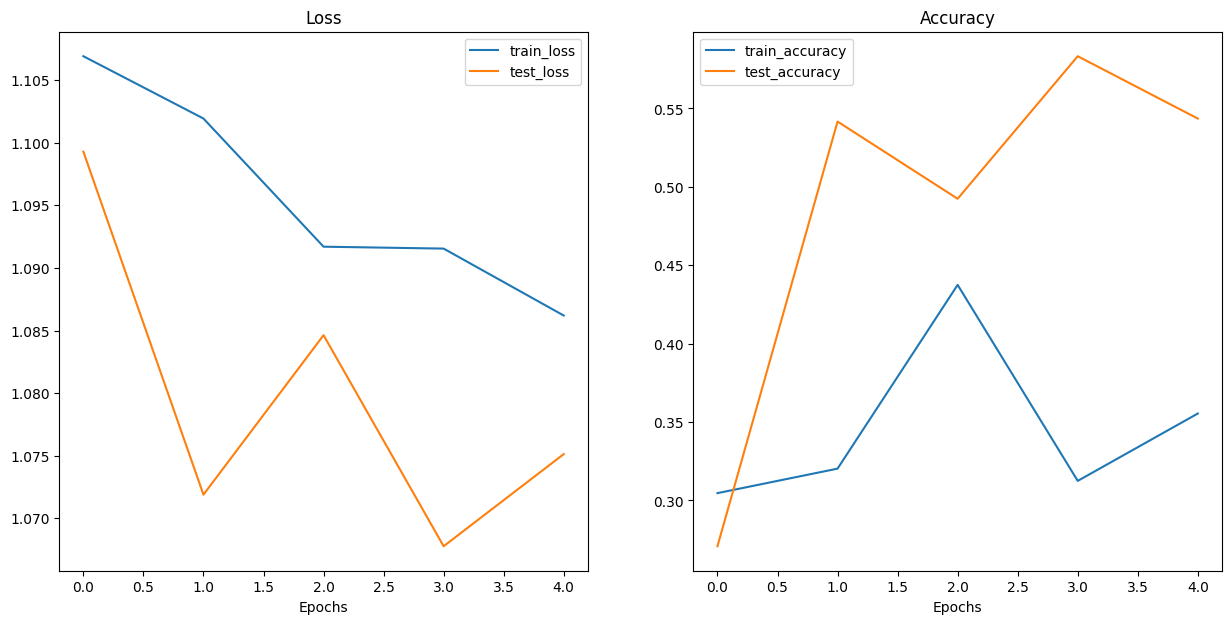

In [59]:
plot_loss_curves(model1_results)

## Making prediction on custom data

i.e. predicting on data that is neither in training data nor in testing data

In [63]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / '04-pizza-dad.jpeg'

if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/04-pizza-dad.jpeg')
    print(f'Downloading {custom_image_path}...')
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists...")

data/04-pizza-dad.jpeg already exists...


### Loading custom image with PyTorch

* in tensor form with dtype torch.float32
* of size (64, 64, 3)
* on device

In [62]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8

RuntimeError: ignored